# 1D Derivative Gaussian Process
## Theory Background
Suppose we have a Gaussian Process (GP) from which we sample a function $f$,
$$ f \sim \mathcal{GP}(\mu_{f}, k_{ff}), $$
where $\mu_{f} = \mu_{f}(x)$ denotes the mean function and $k_{ff} = k_{ff}(x,y)$ denotes the kernel functions. If the mean function and kernel function are differentiable, then the derivatives of the function $f'$ can be sampled from another Gaussian Process by virtue of the general theory of stochastic processes<sup>1</sup>:
$$ f' \sim \mathcal{GP}(\mu_{f}, k_{f'f'}), $$
where
$$ \mu_{f} = \frac{\partial \mu}{\partial x} \ ; \ k_{f'f'} = \frac{\partial k}{\partial y \partial x}. $$

In practice, we want to sample the function $f$ together with its derivative $f'$. This requires a joint model of $f,f'$. The joint distribution of $f,f'$ exists, but it is not necessarily unique. A Gaussian Process model<sup>1</sup> of the joint distribution can be given by:
$$ f, f' \sim \mathcal{GP}(\mu, k), $$
where 
$$ \mu = [\mu_f \ \mu_f'] \ ; \ k = \begin{bmatrix} k_{ff}
 &  k_{ff'} \\ k_{f'f}
 &  k_{f'f'} \\
\end{bmatrix} , $$
The rows (columns) in the augmented kernel matrix correspond to different values of the kernel's first (second) argument. For $k = k(x,y)$, 
$$ k_{f'f} = \frac{\partial k}{\partial{x}} \ ; \ k_{ff'} = \frac{\partial k}{\partial{y}}. $$

To unpack this formal notation, if we want to sample a vector of values of $f$ at inputs $\mathbf{x} = [x_{i}]_{i}$, $\mathbf{f} = f(\mathbf{x})$, and $f'$ at $\mathbf{x}_{D} = [x_{D, j}]_{j}$, $\mathbf{f'} = f'(\mathbf{x}_{D})$ we would use the multivariate normal distribution with 
$$ \mathbf{\mu} = [\mu(\mathbf{x}), \mu'(\mathbf{x}_{D})] \ ; \ \mathbf{K} = \begin{bmatrix} k_{ff}(\mathbf{x}, \mathbf{x}^{T})
 &  k_{ff'}(\mathbf{x}, \mathbf{x}_{D}^{T}) \\ k_{f'f}(\mathbf{x}_{D}, \mathbf{x}^{T})
 &  k_{f'f'}(\mathbf{x}_{D}, \mathbf{x}_{D}^{T}) \\
\end{bmatrix} , $$
where function evaluation of a row vector and a column vector is analogous to taking the outer product of a row and a column vector.

### Footnotes
<sup>1</sup>The key property here is that the derivative (being a linear operator) commutes with the expectation, variance, and covariance operators, as in other stochastic processes. See the Papoulis 1991 Ch. 10 reference listed in [Section 9.4 of R&W][1] for more details.

<sup>2</sup>By the property in the above footnote, this joint GP model is the only such GP model that describes $f,f'$.

<!-- ### References -->
[1]: <https://gaussianprocess.org/gpml/chapters/RW.pdf> "R&W"

## `Tinygp` Implementation of Derivative Kernel

### Reference:
The cell below was taken from the `tinygp` tutorial on [Derivative Observations & Pytree Data][1]. Therefore, it may be useful to refer to that tutorial.

[1]: <https://tinygp.readthedocs.io/en/stable/tutorials/derivative.html> "Derivative Observations & Pytree Data"

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from tinygp import GaussianProcess, kernels

class DerivativeKernel(kernels.Kernel):
    """
    # Joint kernel for 1D function f and its derivatives df/dx

    # Instead of explicitly concatenating f and f' to a larger array, we distinguish f and f' by 
    # introducing a boolean variable d, which is 1 if we sample a derivative and 0 otherwise
    # (ref: https://tinygp.readthedocs.io/en/latest/tutorials/derivative.html)
    # This allows GaussianProcess to take care of vmapping

    # Effectively, [f f'] ~ N(0, K)
    # where K is the joint kernel matrix 
    # K = [[K_ff K_fd], [K_df K_dd]]
    # where K_ff is the kernel matrix for f
    """
    def __init__(self, kernel):
        # initialize the base kernel class
        self.kernel = kernel

    def evaluate(self, X1, X2):
        """
        Analog of the base kernel's .evaluate function, but for the joint kernel

        # Inputs:
        # X1: a tuple (t1, d1) where t1 is the input for f and d1 is a boolean variable indicating whether we sample a derivative
        # X2: a tuple (t2, d2) where t2 is the input for f and d2 is a boolean variable indicating whether we sample a derivative

        # Outputs:
        # the kernel matrix for the joint kernel of f and f'
        """
        t1, d1 = X1
        t2, d2 = X2

        # Differentiate the kernel function: the first derivative wrt x1
        Kp = jax.grad(self.kernel.evaluate, argnums=0)

        # ... and the second derivative
        Kpp = jax.grad(Kp, argnums=1)

        # Evaluate the kernel matrix and all of its relevant derivatives
        K = self.kernel.evaluate(t1, t2)
        d2K_dx1dx2 = Kpp(t1, t2)
        
        # For stationary kernels, these are related just by a minus sign, but we'll
        # evaluate them both separately for generality's sake
        dK_dx2 = jax.grad(self.kernel.evaluate, argnums=1)(t1, t2)
        dK_dx1 = Kp(t1, t2)
        return jnp.where(
            d1, jnp.where(d2, d2K_dx1dx2, dK_dx1), jnp.where(d2, dK_dx2, K)
        )

## Example: Zero-Mean GP

We plot a GP sample $\mathbf{f}$ and its corresponding derivative GP sample $\mathbf{f}'$, evaluated at the same inputs as the original function. We compare the derivative GP sample to the approximate derivative of the sample, computed using finite differences.

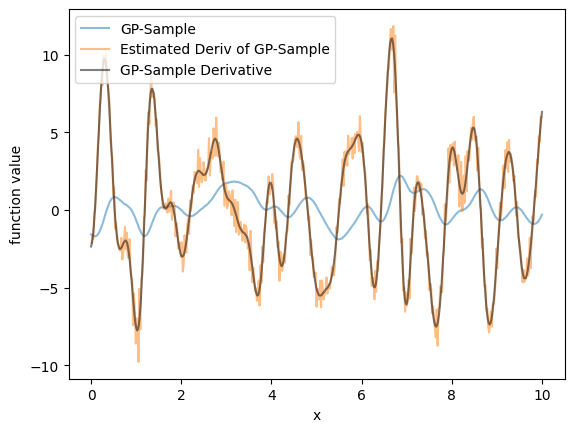

In [2]:
 # input variables
t = np.linspace(0, 10, 500)
Nt = len(t)

# Set up augmented input space for function and derivative
x2 = jnp.concatenate([t,t]) # input variables for function and derivative (x, x_D), inputs are the same
d2 = jnp.concatenate([jnp.zeros_like(t),jnp.ones_like(t)]) # boolean variable indicating whether we sample a derivative
x_aug = jnp.vstack([x2.T,d2.T]).T # augmented input variables

# define derivative kernel
base_kernel = 1. * kernels.ExpSquared(scale=0.25) # base kernel for the GP
kernel = DerivativeKernel(base_kernel) # joint kernel for function and derivative

# define GP object
gp = GaussianProcess(kernel, x_aug, diag = 1e-4) # GP object

# draw single sample of function and derivative from gp
sample = gp.sample(jax.random.PRNGKey(0), shape = (1,))

# plot the function and its derivative
f = sample[0,:Nt]
df = sample[0,Nt:]
plt.plot(t,f, label = 'GP-Sample', alpha = 0.5)
plt.plot(0.5 * (t[1:] + t[:-1]), jnp.diff(f) / jnp.diff(t), label = 'Estimated Deriv of GP-Sample', alpha = 0.5)
plt.plot(t,df, c = 'k', alpha = 0.5, label = 'GP-Sample Derivative')
plt.xlabel('x')
plt.ylabel('function value')
plt.legend()

## Example: GP with Non-Constant Mean Function
We implement a simple, but non-constant mean function. As before, we assess the accuracy by comparing the derivative sample to a finite-difference estimation of the function sample's derivative. 

This is the only time we implement a non-zero mean function throughout the repo!

In [3]:
def mean_function(x):
    return 3. * jnp.sin(x)

def true_mean_derivative(x):
    return 3. * jnp.cos(x)

def mean_function_and_derivative(X):
    """
    As with the derivative kernel, we distinguish between the function and its derivative
    by introducing a boolean variable d. If d is 1, we sample the derivative, otherwise
    we sample the function.

    This allows the GaussianProcess function to take care of appropriate vmapping.

    # Inputs:
    # X: a tuple (t, d) where t is the input for f and d is a boolean variable indicating whether we sample a derivative

    # Outputs:
    # the mean function value or its derivative
    """
    t, d = X
    mean_derivative = jax.grad(mean_function)
    return jnp.where(d, mean_derivative(t), mean_function(t))

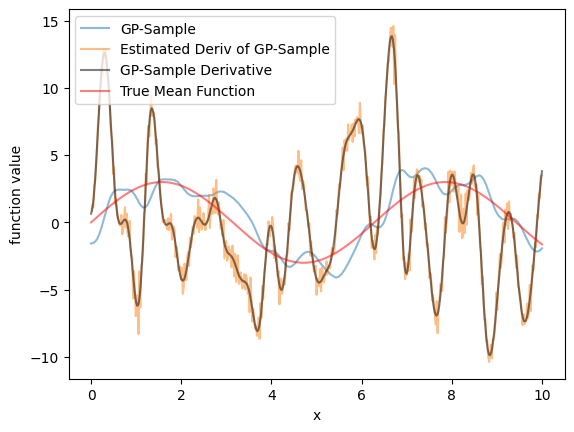

In [4]:
# NOTE: ONLY DIFFERENCE BETWEEN THIS CELL AND THE PREVIOUS ONE IS THE MEAN FUNCTION
# IN THE GP OBJECT

# input variables
t = np.linspace(0, 10, 500)
Nt = len(t)

# Set up augmented input space for function and derivative
x2 = jnp.concatenate([t,t]) # input variables for function and derivative (x, x_D)
d2 = jnp.concatenate([jnp.zeros_like(t),jnp.ones_like(t)]) # boolean variable indicating whether we sample a derivative
x_aug = jnp.vstack([x2.T,d2.T]).T # augmented input variables

# define derivative kernel
base_kernel = 1. * kernels.ExpSquared(scale=0.25) # base kernel for the GP
kernel = DerivativeKernel(base_kernel) # joint kernel for function and derivative

# define GP object
gp = GaussianProcess(kernel, x_aug, diag = 1e-4, mean = mean_function_and_derivative) # GP object

# draw single sample of function and derivative from gp
sample = gp.sample(jax.random.PRNGKey(0), shape = (1,))

# plot the function and its derivative
f = sample[0,:Nt]
df = sample[0,Nt:]
plt.plot(t,f, label = 'GP-Sample', alpha = 0.5)
plt.plot(0.5 * (t[1:] + t[:-1]), jnp.diff(f) / jnp.diff(t), label = 'Estimated Deriv of GP-Sample', alpha = 0.5)
plt.plot(t,df, c = 'k', alpha = 0.5, label = 'GP-Sample Derivative')
plt.plot(t, mean_function(t), label = 'True Mean Function', alpha = 0.5, c = 'r')
plt.xlabel('x')
plt.ylabel('function value')
plt.legend()

Generate 100,000 Samples estimate 90\% Probability Bound of Functions and Derivatives

Text(0.5, 1.0, 'Derivative')

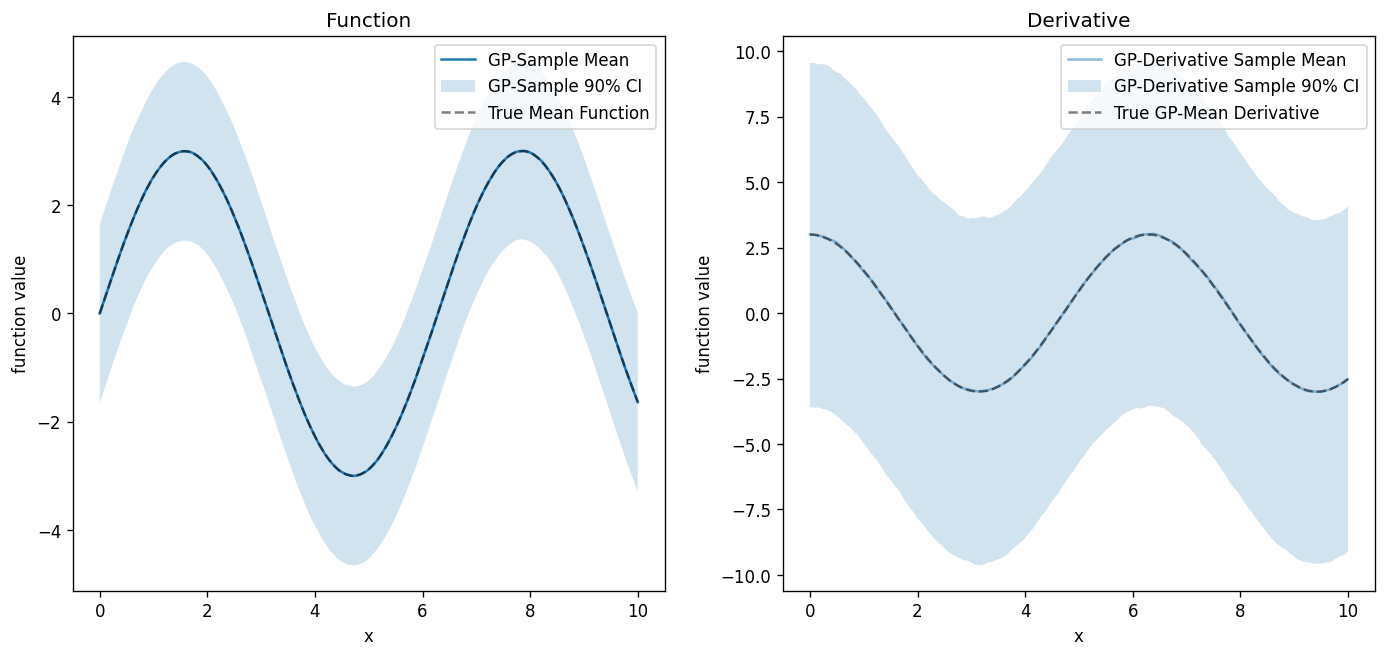

In [5]:
# input variables
t = np.linspace(0, 10, 500)
Nt = len(t)

# Set up augmented input space for function and derivative
x2 = jnp.concatenate([t,t]) # input variables for function and derivative (x, x_D)
d2 = jnp.concatenate([jnp.zeros_like(t),jnp.ones_like(t)]) # boolean variable indicating whether we sample a derivative
x_aug = jnp.vstack([x2.T,d2.T]).T # augmented input variables

# define derivative kernel
base_kernel = 1. * kernels.ExpSquared(scale=0.25) # base kernel for the GP
kernel = DerivativeKernel(base_kernel) # joint kernel for function and derivative

# define GP object
gp = GaussianProcess(kernel, x_aug, diag = 1e-4, mean = mean_function_and_derivative) # GP object

# draw single sample of function and derivative from gp
N_samples = 100000
sample = gp.sample(jax.random.PRNGKey(0), shape = (N_samples,))

# plot the function and its derivative
fig = plt.figure(figsize=(14, 6), dpi= 120)
ax = fig.add_subplot(1,2,1)
qf = np.percentile(sample[:,:Nt], [5, 50, 95], axis = 0)
ax.plot(t, qf[1], label = 'GP-Sample Mean', alpha = 1.)
ax.fill_between(t, qf[0], qf[2], alpha = 0.2, label = 'GP-Sample 90% CI')
ax.plot(t, mean_function(t), c = 'k', label = 'True Mean Function', alpha = 0.5, ls = '--')
ax.set_xlabel('x')
ax.set_ylabel('function value')
ax.legend()
ax.set_title('Function')

ax = fig.add_subplot(1,2,2)
qdf = np.percentile(sample[:,Nt:], [5, 50, 95], axis = 0)
ax.plot(t, qdf[1], label = 'GP-Derivative Sample Mean', alpha = 0.5)
ax.fill_between(t, qdf[0], qdf[2], alpha = 0.2, label = 'GP-Derivative Sample 90% CI')
plt.plot(t,true_mean_derivative(t), c = 'k', alpha = 0.5, label = 'True GP-Mean Derivative', ls = '--')
ax.set_xlabel('x')
ax.set_ylabel('function value')
ax.legend()
ax.set_title('Derivative')